In [ ]:
%pip install torch torchvision pandas numpy matplotlib pillow seaborn scikit-learn opencv-python
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import xml.etree.ElementTree as ET
import seaborn as sns
from skimage import io
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

Define dataset paths and load df of parsed xml from class imageRead

In [10]:
dataset_pth = 'C:/MAMP/htdocs/2025_GP_27/model1/newDataset_images'
annotations_pth = 'C:/MAMP/htdocs/2025_GP_27/model1/annotations'
image_files = sorted([f for f in os.listdir(dataset_pth) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))])
xml_files = sorted([f for f in os.listdir(annotations_pth) if f.lower().endswith('.xml')])
%store -r df


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Stored 'df' (DataFrame)
Created DataFrame with 3231 samples
Checking for inconsistencies, missing files, and data issues...

CHECKING IMAGE-XML CORRESPONDENCE:
   Checked 0/3231 files...
   Checked 500/3231 files...
   Checked 1000/3231 files...
   Checked 1500/3231 files...
   Checked 2000/3231 files...
   Checked 2500/3231 files...
   Checked 3000/3231 files...
Finished checking 3231 xml files.
Missing images: 316, XML parse errors: 0, issues_found: 316
The missing images are: [('normal_pressure_1.xml', '136.png'), ('normal_pressure_10.xml', '145.png'), ('normal_pressure_100.xml', '235.png'), ('normal_pressure_101.xml', '236.png'), ('normal_pressure_102.xml', '237.png'), ('normal_pressure_103.xml', '238.png'), ('normal_pressure_104.xml', '239.png'), ('normal_pressure_105.xml', '240.png'), ('normal_pressure_106.xml', '241.png'), ('normal_pressure_107.xml'

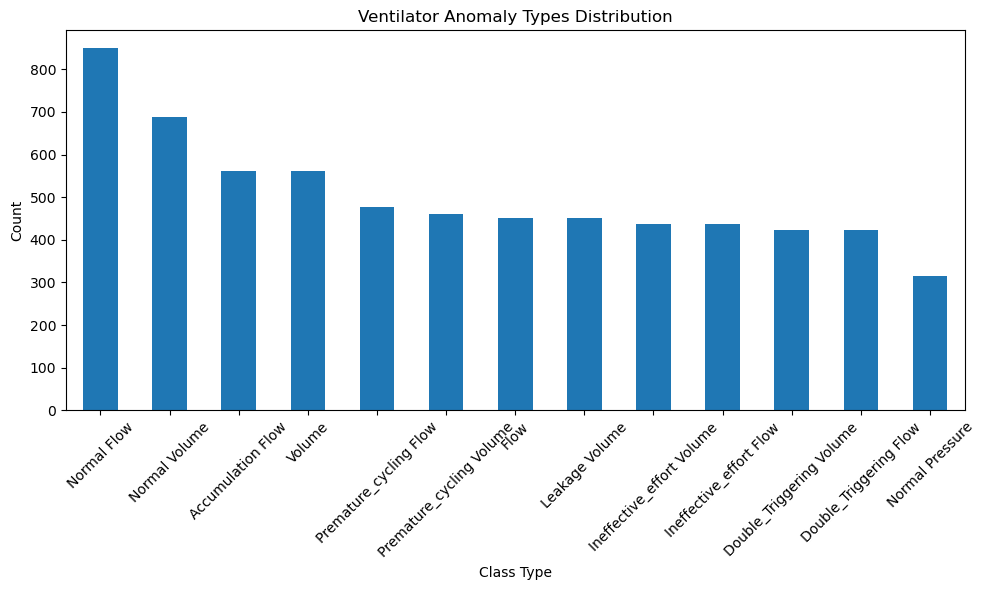

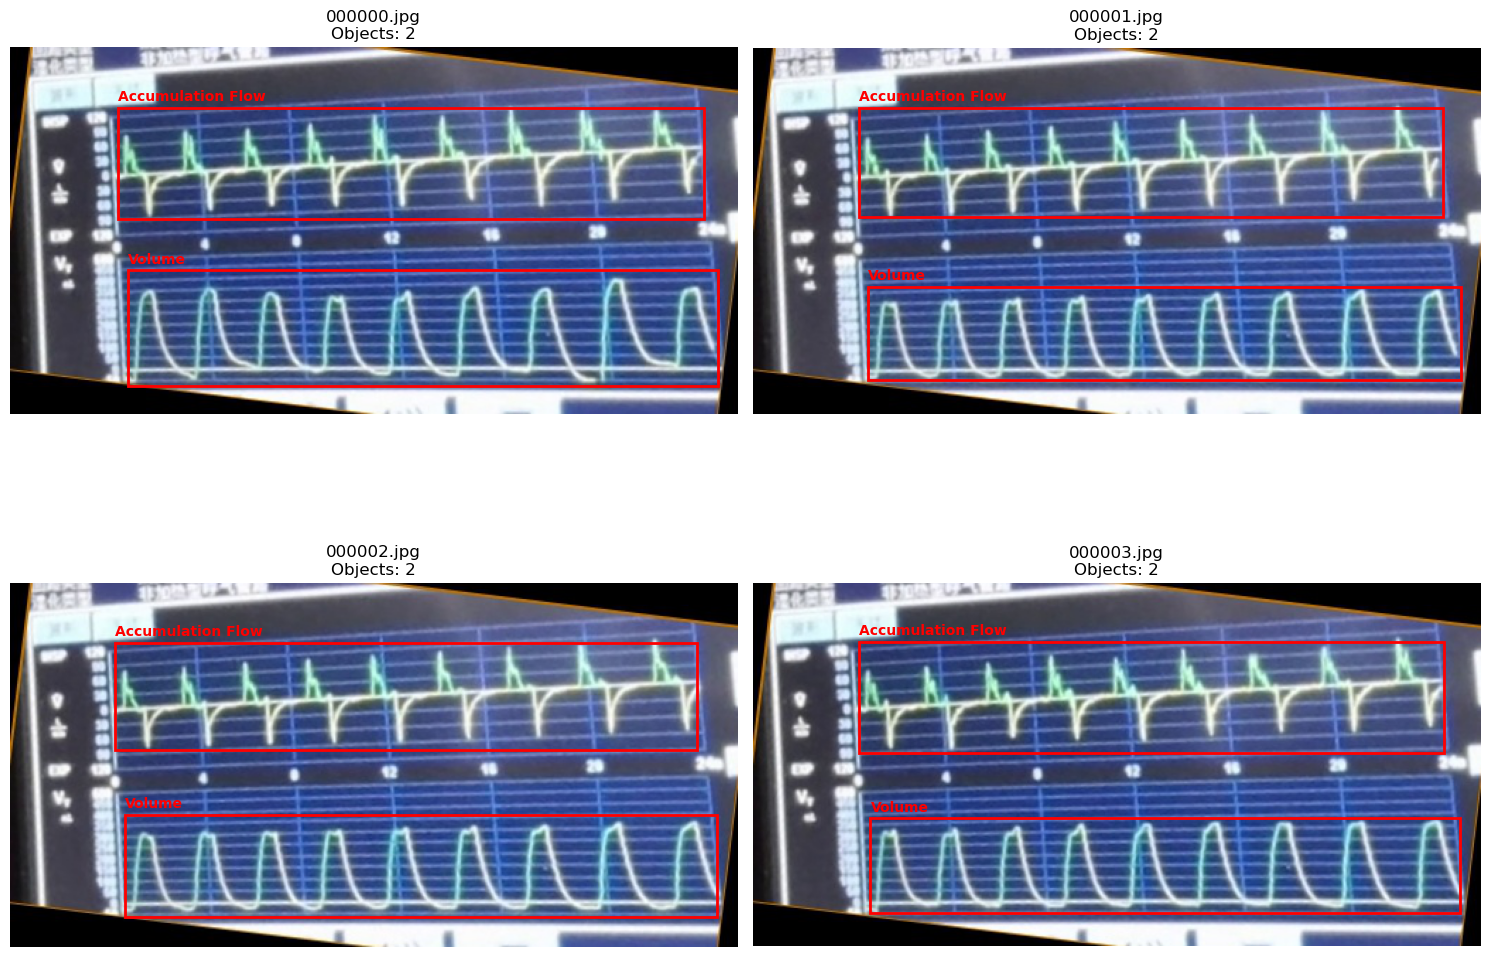

=== TESTING DIFFERENT BACKGROUND REGIONS ===
top_left: STD = 64.06, Mean = 191.16
Region: top_left, Noise STD: 64.05723889897222
top_right: STD = 55.87, Mean = 72.50
Region: top_right, Noise STD: 55.874706257482906
bottom_left: STD = 53.49, Mean = 54.75
Region: bottom_left, Noise STD: 53.48695243365432
bottom_right: STD = 57.67, Mean = 124.85
Region: bottom_right, Noise STD: 57.6729907197468
center_top: STD = 23.02, Mean = 84.30
Region: center_top, Noise STD: 23.024968707904907

=== NOISE ASSESSMENT ===
000000.jpg: Noisy (STD: 35.3) - Denoise: True
000001.jpg: Noisy (STD: 29.8) - Denoise: True
000002.jpg: Noisy (STD: 32.9) - Denoise: True
000003.jpg: Noisy (STD: 37.5) - Denoise: True
000004.jpg: Noisy (STD: 35.3) - Denoise: True
000005.jpg: Noisy (STD: 39.0) - Denoise: True
000006.jpg: Noisy (STD: 32.4) - Denoise: True
000007.jpg: Noisy (STD: 32.9) - Denoise: True
000008.jpg: Noisy (STD: 36.3) - Denoise: True
000009.jpg: Noisy (STD: 36.2) - Denoise: True

 DATASET NOISE SUMMARY:
Averag

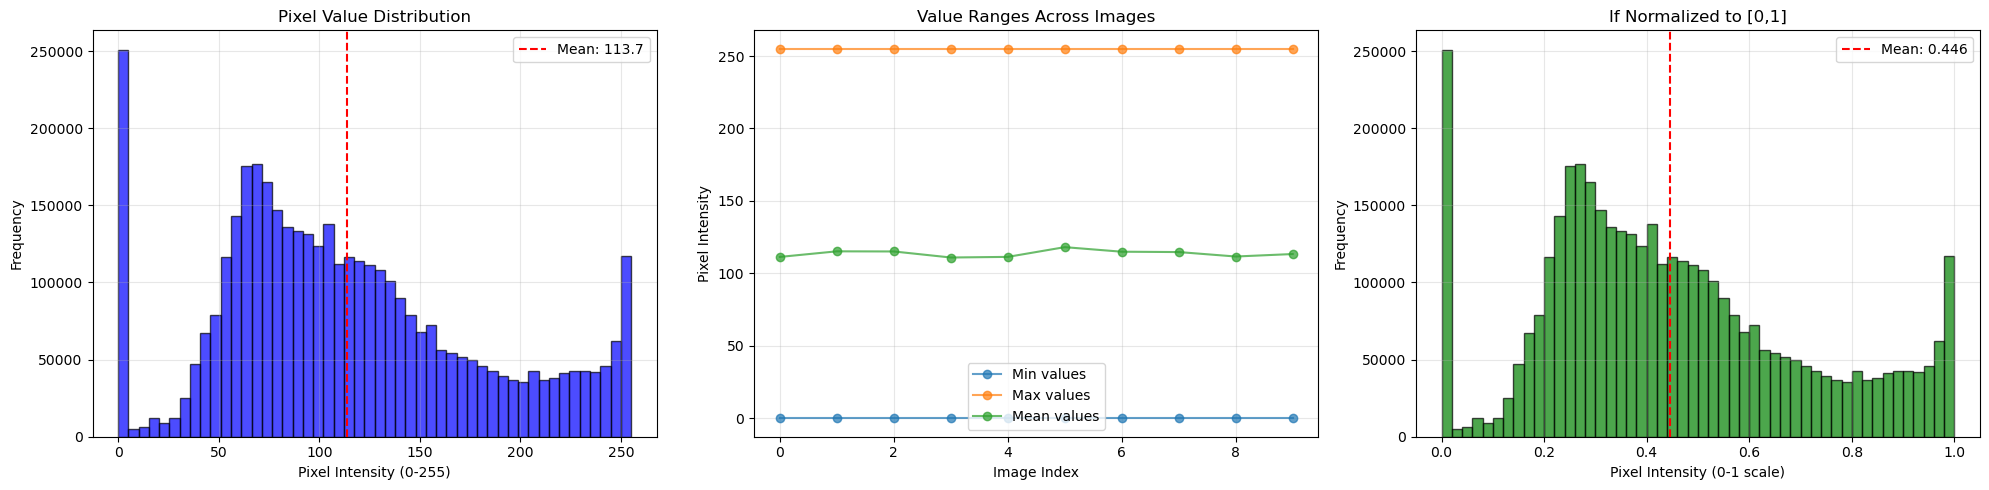

=== NORMALIZATION STATUS ANALYSIS ===
Data appears to be on scale: 
  [0, 255] scale: True
  [0, 1] scale: False
  [-1, 1] scale: False
CONCLUSION: Data is in standard 0-255 range
   Normalization to [0,1] is REQUIRED for ML models
Analyzing image quality for sample images...

Image Quality Summary:
     filename        size  mean_intensity  contrast  noise_std
0  000000.jpg  (514, 259)      105.300340       255  46.555255
1  000001.jpg  (515, 259)      108.953436       255  44.678550
2  000002.jpg  (515, 258)      108.875728       255  44.819154
3  000003.jpg  (515, 257)      104.786461       255  46.555382
4  000004.jpg  (516, 258)      105.304714       255  47.218437
5  000005.jpg  (517, 258)      111.505803       255  46.367310
6  000006.jpg  (515, 258)      108.640250       255  44.297107
7  000007.jpg  (516, 258)      108.448027       254  45.161165
8  000008.jpg  (517, 260)      105.622080       255  44.997835
9  000009.jpg  (513, 259)      107.323609       255  44.668624


In [21]:
%run imageRead.ipynb

In [11]:
#Ensure df is loaded
print("DataFrame loaded with", len(df), "rows")

DataFrame loaded with 3231 rows


Clean df from filenames, build full image paths, remove missing files

In [16]:
df['image_name'] = df['image_name'].astype(str)
df['image_name'] = df['image_name'].str.replace('\t', '', regex=False)
df['image_name'] = df['image_name'].str.strip()

df['image_path'] = df['image_name'].apply(lambda x: os.path.join(dataset_pth, x))

print("Sample image names and paths:")
print(df[['image_name', 'image_path']].head())

# Find annotations with missing image files
missing = df[~df['image_path'].apply(os.path.exists)]
print("Number of missing image files:", len(missing))

if len(missing) > 0:
    print("Example of missing files:")
    print(missing[['image_name', 'image_path']].head())

df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)
print("After removing missing images, total rows:", len(df))

missing_after = df[~df['image_path'].apply(os.path.exists)]
print("After cleaning, missing files:", len(missing_after))


Sample image names and paths:
   image_name                                         image_path
0  000000.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
1  000001.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2  000002.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
3  000003.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
4  000004.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
Number of missing image files: 0
After removing missing images, total rows: 2915
After cleaning, missing files: 0


Denoise Transform using Edge preserving

In [113]:
# ----  denoising transform (edge-preserving) ----
class DenoiseTransform:
    """
    Apply gentle, edge-preserving denoising using OpenCV fastNlMeansDenoisingColored.
    Input : PIL Image (RGB)
    Output: PIL Image (RGB) after noise reduction
    """
    def __call__(self, img_pil):
        # Convert PIL -> NumPy (RGB)
        img_np = np.array(img_pil)

        # OpenCV expects BGR, so convert if needed
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        # Apply gentle denoising (small h values to avoid over-smoothing)
        denoised_bgr = cv2.fastNlMeansDenoisingColored(
            img_bgr,
            None,
            h=6,          # luminance filter strength
            hColor=6,     # color filter strength
            templateWindowSize=7,
            searchWindowSize=21
        )

        # Back to RGB
        denoised_rgb = cv2.cvtColor(denoised_bgr, cv2.COLOR_BGR2RGB)

        # Convert back to PIL
        return Image.fromarray(denoised_rgb)

Image: 000000.jpg


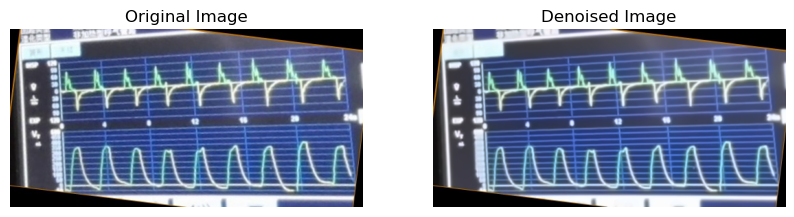

Image: 000001.jpg


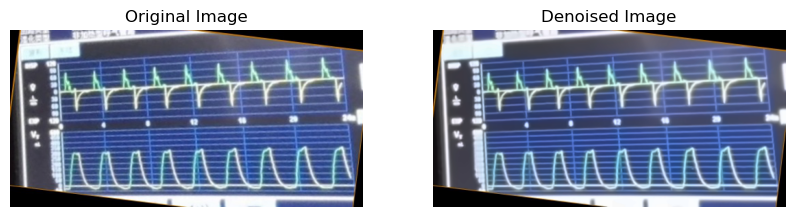

Image: 000002.jpg


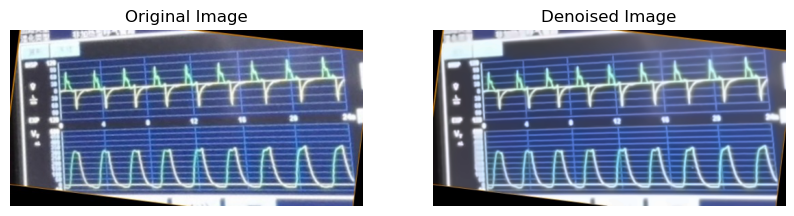

Image: 000003.jpg


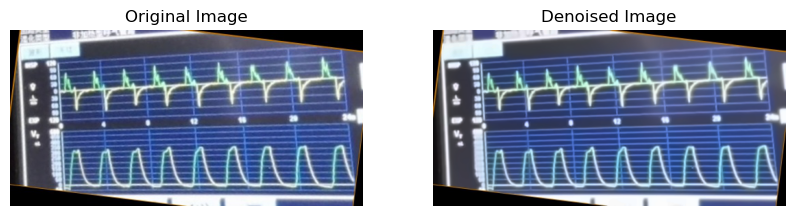

Image: 000004.jpg


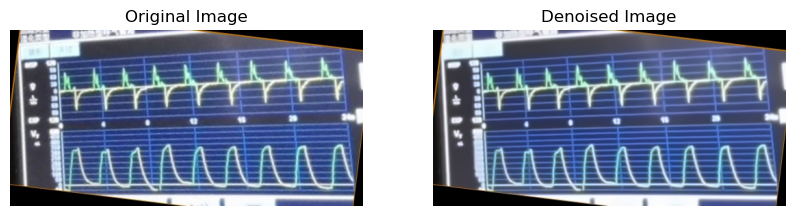

In [114]:
for image_file in image_files[:5]:
    img_path = os.path.join(dataset_pth, image_file)
    row = df[df['image_name'] == image_file].iloc[0]
    denoise_transform = DenoiseTransform()
    original_img = Image.open(img_path).convert('RGB')
    denoised_img = denoise_transform(original_img)
    
    
    print(f"Image: {row['image_name']}")
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title("Denoised Image")
    plt.imshow(denoised_img)
    plt.axis('off')
    plt.show()

Normalization of image data

In [111]:
print("=== NORMALIZATION PIXELS [0,1] ===")

for image_file in image_files:
    img_path = os.path.join(dataset_pth, image_file)
    image_pil = Image.open(img_path)
    image_array = np.array(image_pil)
 
    # normalization to [0,1]
    normalized = image_array.astype(np.float32) / 255.0

    print(f"\n{image_file}:")
    print(f"   Original range: [{image_array.min()}, {image_array.max()}]")
    print(f"   After /255:     [{normalized.min():.3f}, {normalized.max():.3f}]")    
    print(f"   First pixel values:")
    print(f"     Original: {image_array[0,0,:]}")
    print(f"     After /255: {normalized[0,0,:]}")


=== NORMALIZATION PIXELS [0,1] ===

000000.jpg:
   Original range: [0, 255]
   After /255:     [0.000, 1.000]
   First pixel values:
     Original: [1 0 4]
     After /255: [0.00392157 0.         0.01568628]

000001.jpg:
   Original range: [0, 255]
   After /255:     [0.000, 1.000]
   First pixel values:
     Original: [1 0 4]
     After /255: [0.00392157 0.         0.01568628]

000002.jpg:
   Original range: [0, 255]
   After /255:     [0.000, 1.000]
   First pixel values:
     Original: [0 0 4]
     After /255: [0.         0.         0.01568628]

000003.jpg:
   Original range: [0, 255]
   After /255:     [0.000, 1.000]
   First pixel values:
     Original: [0 0 2]
     After /255: [0.         0.         0.00784314]

000004.jpg:
   Original range: [0, 255]
   After /255:     [0.000, 1.000]
   First pixel values:
     Original: [0 0 4]
     After /255: [0.         0.         0.01568628]

000005.jpg:
   Original range: [0, 255]
   After /255:     [0.000, 1.000]
   First pixel values:
  

Split into train, validation, and test sets

In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=df_tanafs['clinical_label_id']  
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=temp_df['clinical_label_id']    
)


print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


Train: 997 Val: 214 Test: 214


plits the cleaned and filtered dataset into:

70% training

15% validation

15% test


 Define image transforms (resize, normalize, augment)

In [ ]:
IMG_SIZE = 224  

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),    
    DenoiseTransform(),
    #  Data augmentation (only for training)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    # Convert to tensor [0,1]
    transforms.ToTensor(),
    # Normalize with ImageNet stats (needed for transfer learning)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  
        std=[0.229, 0.224, 0.225]    
    ),
])
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    DenoiseTransform(),   # optional but preferred for medical images
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

Create custom Dataset and DataLoaders

In [76]:
class TanafsClinicalDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = row['image_path']

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label_id = int(row['clinical_label_id'])

        labels = torch.tensor(label_id, dtype=torch.long)

        return image, labels



BATCH_SIZE = 16

train_dataset = TanafsClinicalDataset(train_df, transform=train_transform)
val_dataset   = TanafsClinicalDataset(val_df,   transform=val_test_transform)
test_dataset  = TanafsClinicalDataset(test_df,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [77]:
images, labels = next(iter(train_loader))
print("Images shape:", images.shape)   
print("Labels shape:", labels.shape)   
print("First label vector:", labels[0])


Images shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])
First label vector: tensor(1)


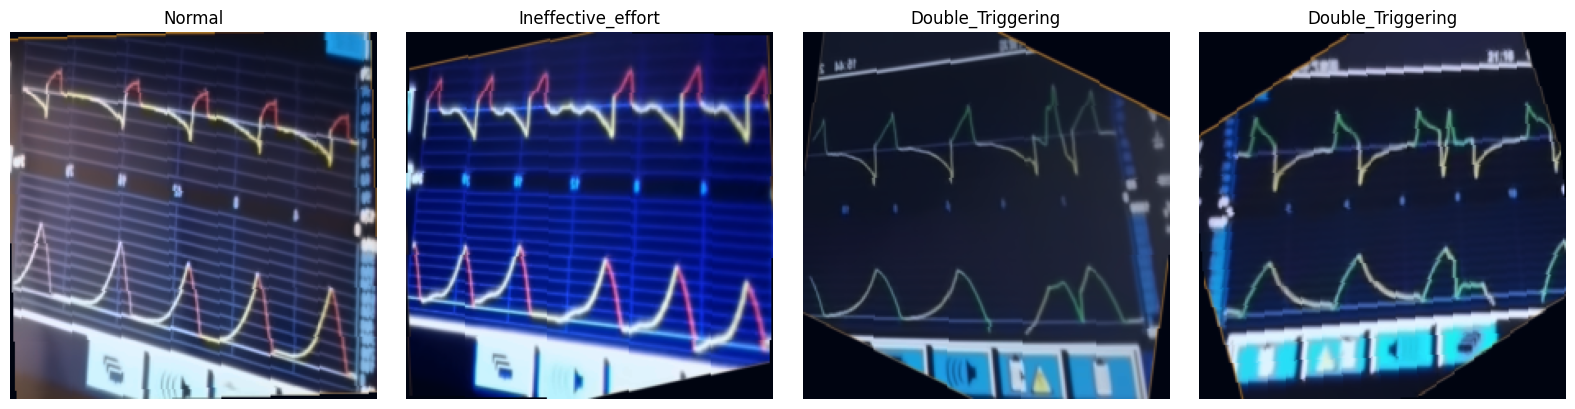

In [78]:

def show_batch(images, labels, classes, n=4):
  
    # Denormalize (approx) just for visualization
    imgs = images[:n].clone()
    imgs = imgs.permute(0, 2, 3, 1)  # [B, H, W, 3]

    plt.figure(figsize=(4 * n, 4))
    
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = imgs[i].numpy()
        
        # put valid range for display
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        ax.imshow(img)

        cls_id = int(labels[i].item())        
        cls_name = classes[cls_id]             

        ax.set_title(cls_name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
images, labels = next(iter(train_loader))


show_batch(images, labels, CLINICAL_CLASSES, n=4)
